In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation

import operator
import matplotlib
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# (1) read in data
print("Load the training, test and store data using pandas")
types = {'StateHoliday': np.dtype(str),
         'SchoolHoliday': np.dtype(float),
         'PromoInterval': np.dtype(str),
         'Assortment': np.dtype(str), 
         'PromoInterval': np.dtype(str),
         'StoreType': np.dtype(str)
        }


train_df = pd.read_csv("../data/train.csv", dtype=types)
store_df = pd.read_csv("../data/store.csv", dtype=types, keep_default_na=False, na_values= '')
test_df = pd.read_csv("../data/test.csv", dtype=types)

Load the training, test and store data using pandas


In [3]:
# (2) show data feature
#train_df[0:10]

In [4]:
#store_df[0:10]

In [5]:
# show all data features
'''print("\n"+"----train-------")
train_df.info()
print("\n"+"----store----------")
store_df.info()
print("\n"+"----test----------")
test_df.info()'''

'print("\n"+"----train-------")\ntrain_df.info()\nprint("\n"+"----store----------")\nstore_df.info()\nprint("\n"+"----test----------")\ntest_df.info()'

In [6]:
def describe_object(X):
    # return object variables only
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))
    
def show_object(X):
    category=np.unique(list(X.select_dtypes(['object'])))
    print("------------------Categorical Columns---------------------")
    print(category)
    print("\n")
    print("------------List all----------------------")
    for column in category:
        {
        print(column + ':' + str(np.unique(list(X[column])))+'\n')
        }

def show_object_No(X, No):
    category=np.unique(list(filter(lambda x: x!= No, X.select_dtypes(['object']))))
    print("----------Categorical Columns------remove-"+No+"--------------")
    print(category)
    print("\n")
    print("------------List all----------------------")
    for column in category:
        {
        print(column + ':' + str(np.unique(list(X[column])))+'\n')
        }
        
def show_object_NoList(X, NoList):
    category=np.unique(list(filter(lambda x: (x not in NoList), X.select_dtypes(['object']))))
    print("----------Categorical Columns---remove----"+', '.join(NoList)+"--------------")
    print(category)
    print("\n")
    print("------------List all----------------------")
    for column in category:
        {
        print(column + ':' + str(np.unique(list(X[column])))+'\n')
        }
        
def dummy_object(df, Object_List):
    df2 = df
    for x in Object_List:
        df[x].fillna("Missing", inplace=True) # Missing is also maybe a option for categorize
        dummies = pd.get_dummies(df[x], prefix=x, prefix_sep="dummy") # create dummies array
        df2 = pd.concat([df2, dummies], axis=1) # put together previous put df here only get last concat
        df2.drop([x],axis=1, inplace=True)
    return df2

def String_list_find(list, spec):
    result = []
    for string in list:
        if string.find(spec) != -1:
            result.append(string)
    return result

def List_diffa(a, b):
    b = set(b)
    return [aa for aa in a if aa not in b]

In [7]:
'''print("----------------------------train Data---------------------------------")
describe_object(train_df)
show_object_No(train_df,'Date')
print("-----------------------------test Data-----------------------------")
describe_object(test_df)
show_object_No(test_df,'Date')
print("----------------------------store Data-------------------------------")
describe_object(store_df)
show_object(store_df)'''

'print("----------------------------train Data---------------------------------")\ndescribe_object(train_df)\nshow_object_No(train_df,\'Date\')\nprint("-----------------------------test Data-----------------------------")\ndescribe_object(test_df)\nshow_object_No(test_df,\'Date\')\nprint("----------------------------store Data-------------------------------")\ndescribe_object(store_df)\nshow_object(store_df)'

In [8]:
# features_build: features List;  data (data frame in -> data frame out)
def features_build(features, data):
    # fill nan with 0
    data.fillna(0, inplace=True)
    #data.loc[data.open.isnull(), 'Open'] =1
    #features as a list to store reference columns for training
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])
    
    # add columns (features list and then data import)
    #(1) categorical to 12345 mapping
    '''features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'a':1, 'b':2, 'c':3, 'd':4, '0':0}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)'''
    #(1) dummy
    dummy_str=['StoreType', 'Assortment', 'StateHoliday']
    #print("input dataframe index")
    #print(data.dtypes.index)
    data=dummy_object(data, dummy_str)
    #print("output dataframe index after dummy")
    #print(data.dtypes.index)
    features.extend(String_list_find(list(data.dtypes.index),'dummy'))
    
    
    #(2) Date 
    features.extend(['DayofWeek', 'Month', 'Day', 'Year', 'WeekofYear'])
    data['Year'] = pd.to_datetime(data.Date).dt.year
    data['Month'] = pd.to_datetime(data.Date).dt.month
    data['Day'] = pd.to_datetime(data.Date).dt.day
    data['DayofWeek'] = pd.to_datetime(data.Date).dt.dayofweek
    data['WeekofYear'] = pd.to_datetime(data.Date).dt.weekofyear
    
    #(3) Other time
    features.extend(['CompetitionOpenMonth'])
    data['CompetitionOpenMonth'] = (data.Month - data.CompetitionOpenSinceMonth) + 12 * (data.Year - data.CompetitionOpenSinceYear)
    
    features.extend(['Promo2SinceMonth'])
    data['Promo2SinceMonth'] = (data.WeekofYear - data.Promo2SinceWeek)/4 + 12 * (data.Year - data.Promo2SinceYear)
    data['Promo2SinceMonth'] = data.Promo2SinceMonth.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'Promo2SinceMonth'] = 0
    
    
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
                
    return data



In [9]:
##

In [10]:
print("Assume store open, if not provided")
test_df.fillna(1, inplace=True)

print("Consider only open stores for training. Closed stores wont count into the score.")
train_df = train_df[train_df["Open"] != 0]
print("Use only Sales bigger then zero")
train_df = train_df[train_df["Sales"] > 0]

print("Join with store")
train_df = pd.merge(train_df, store_df, on='Store')
test_df = pd.merge(test_df, store_df, on='Store')
#print(train_df.dtypes.index)
#print(test_df.dtypes.index)

Assume store open, if not provided
Consider only open stores for training. Closed stores wont count into the score.
Use only Sales bigger then zero
Join with store


In [11]:
features = []

print("augment features")
train_df = features_build(features, train_df)
#print(features)
test_df = features_build([], test_df)

# add new columns (with zero) to test_df, these columns are in training, not in testing
train_columns = list(train_df.dtypes.index)
test_columns = list(test_df.dtypes.index)
train_more = List_diffa(train_columns, test_columns)
for col in train_more:
    test_df[col]=0


print('training data processed')

def rmspe(y, yhat):
    return np.sqrt(np.mean(((y - yhat)/y) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)


augment features
training data processed


In [12]:
#check columns in training and testing
#print(train_df.dtypes.index)
#print("----------------------")
#print(test_df.dtypes.index)

In [13]:
print("Train xgboost model Parameters")

params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.02, #0.1
          "max_depth": 10,
          "subsample": 0.9, #0.85
          "colsample_bytree": 0.7, #0.4 
          "min_child_weight": 6,
          "silent": 1,
          "thread": 1,
          "seed": 1301
          }
num_boost_round = 300

Train xgboost model Parameters


In [14]:
print("Train a XGBoost model")
X_train, X_valid = train_test_split(train_df, test_size=0.012, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)


Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.999837	eval-rmspe:0.999837
[1]	train-rmspe:0.999779	eval-rmspe:0.999779
[2]	train-rmspe:0.999712	eval-rmspe:0.999711
[3]	train-rmspe:0.999635	eval-rmspe:0.999634
[4]	train-rmspe:0.999547	eval-rmspe:0.999546
[5]	train-rmspe:0.999447	eval-rmspe:0.999446
[6]	train-rmspe:0.999333	eval-rmspe:0.999333
[7]	train-rmspe:0.999205	eval-rmspe:0.999204
[8]	train-rmspe:0.999061	eval-rmspe:0.999060
[9]	train-rmspe:0.998897	eval-rmspe:0.998896
[10]	train-rmspe:0.998714	eval-rmspe:0.998713
[11]	train-rmspe:0.998509	eval-rmspe:0.998508
[12]	train-rmspe:0.998281	eval-rmspe:0.998280
[13]	train-rmspe:0.998026	eval-rmspe:0.998025
[14]	train-rmspe:0.997744	eval-rmspe:0.997743
[15]	train-rmspe:0.997432	eval-rmspe:0.997431
[16]	train-rmspe:0.997086	eval-rmspe:0.997086
[17]	train-rmspe:0.996705	eval-rmspe:0.996705
[18]	train-rmspe:0.996287	eval-rmspe:0.996287
[19]	train-rmspe:0.995827	eval-rmspe:0.995827
[20]	train-rmspe:0.995325	eval

Train a XGBoost model


[299]	train-rmspe:0.264694	eval-rmspe:0.231187


In [15]:
print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

print("Make predictions on the test set")
dtest = xgb.DMatrix(test_df[features])
test_probs = gbm.predict(dtest)
# Make Submission
result = pd.DataFrame({"Id": test_df["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv("xgboost_10_submission_3.csv", index=False)

Validating
RMSPE: 0.231187
Make predictions on the test set


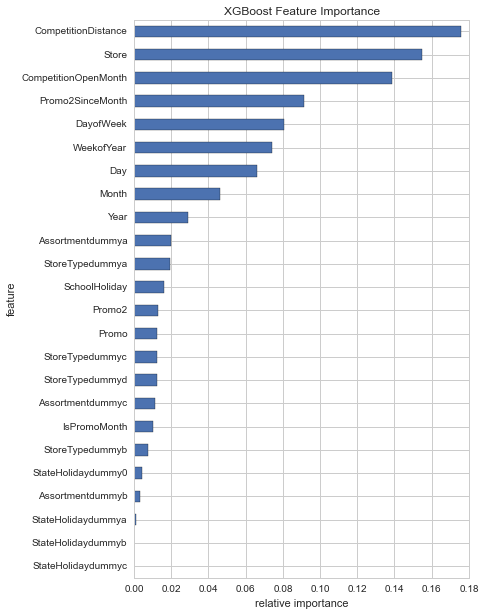

In [16]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()


create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
import matplotlib.pyplot as plt
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb_3.png', bbox_inches='tight', pad_inches=1)
